# Toxicity classification using BERT

**Description:** This notebook builds a classification model by fine tuning BERT to label comments with 6 classes 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'.

The data used for training the model was originally sourced from [Kaggle Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge). 

<a id = 'returnToTop'></a>

## Notebook Contents
  * 1. [Setup](#setup) 
  * 2. [Data](#data)  
  * 3. [Tokenization](#tokenization)
  * 4. [Model Training](#training)
  * 5. [Model Evaluation](#evaluation)


<a id = 'setup'></a>

## 1. Setup

Install required libraries

In [27]:
!pip install transformers --quiet

Import required libraries

In [28]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

In [29]:
from transformers import BertTokenizer, TFBertModel

[Return to Top](#returnToTop)  
<a id = 'data'></a>

## 2. Data

The jigsaw database has been downloaded from kaggle, cleaned and preprocessed and split into train, validation and test datasets. The datsets are stored on amazon S3 where we will be accessing them from.

In [30]:
LOAD_TEST_DATA = True

In [31]:
if (LOAD_TEST_DATA):
  from google.colab import drive
  drive.mount('/content/drive')

  df_train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/w266project/train_data.csv")
  df_valid = pd.read_csv("/content/drive/My Drive/Colab Notebooks/w266project/validation_data.csv")
  df_test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/w266project/test_data.csv")
  
else:
  df_train = pd.read_csv("https://adamhyman-public.s3.amazonaws.com/train_data.csv")

  df_valid = pd.read_csv("https://adamhyman-public.s3.amazonaws.com/validation_data.csv")

  df_test = pd.read_csv("https://adamhyman-public.s3.amazonaws.com/test_data.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
df_train.head()

,Unnamed: 0,comment_text,obscene,threat,insult,toxic,severe_toxic,identity_hate
0,19497,how time changes things juneau the states most...,0,0,0,0,0,0
1,28495,hawaii has been in the center of the nuclear b...,0,0,0,0,0,0
2,604,not all alaskans are not as dumb as you,0,0,1,1,0,0
3,8666,you should read rape culture in the alaska wil...,0,0,1,1,0,0
4,13161,giving stupid kids a chance not to f up thier ...,0,0,1,1,0,0


In [33]:
#split input and output variables
train_comments, train_labels = df_train["comment_text"], df_train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
valid_comments, valid_labels = df_valid["comment_text"], df_valid[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
test_comments, test_labels = df_test["comment_text"], df_test[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

In [34]:
#covert to tensors
train_comments, train_labels = tf.convert_to_tensor(train_comments), tf.convert_to_tensor(train_labels)
valid_comments, valid_labels = tf.convert_to_tensor(valid_comments), tf.convert_to_tensor(valid_labels)
test_comments, test_labels = tf.convert_to_tensor(test_comments), tf.convert_to_tensor(test_labels)

In [35]:
#verify input data
train_comments[:4]

<tf.Tensor: shape=(4,), dtype=string, numpy=
array([b'how time changes things juneau the states most liberal community voted against fluoride in public water and anti vax ers are proliferate as far as how red the little red school was in juneau at least it was pretty deep red after all it did produce several notable far left politicians including one former mayor and attorney general ',
       b'hawaii has been in the center of the nuclear bulls eye since the 50 s russia and china can instantly vaporize oahu and the west coast but they like nk know their countries would be completely destroyed in doing so there is no such thing as limited nuclear warfare all human s should be very nervous about the use of wmds wmd s have made warfare between people for whatever reason suicidal and obsolete no one wins hopefully we will not have to learn the hard way that this is true but that s how we roll',
       b'not all alaskans are not as dumb as you ',
       b'you should read rape culture in th

In [36]:
#verify outpit labels
train_labels[:4]

<tf.Tensor: shape=(4, 6), dtype=int64, numpy=
array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 1, 0]])>

[Return to Top](#returnToTop)  
<a id = 'tokenization'></a>
## 3. Tokenization

Get the pre-trained BERT model and tokenizer.

In [37]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [38]:
# BERT Tokenization of training and validation data
MAX_SEQUENCE_LENGTH = 128                 # set max_length of the input sequence

train_examples = [x.decode('utf-8') for x in train_comments.numpy()]
valid_examples = [x.decode('utf-8') for x in valid_comments.numpy()]

x_train = bert_tokenizer(train_examples,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_train = train_labels

x_valid = bert_tokenizer(valid_examples,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_valid = valid_labels

[Return to Top](#returnToTop)  
<a id = 'model'></a>

# 4. Model definition and training


Define the model...

In [39]:
def create_bert_classification_model(bert_model,
                                     num_train_layers=0,
                                     hidden_size=200, 
                                     dropout=0.3,
                                     learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes
    """
    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False

    elif num_train_layers == 12: 
        # Train all layers of the BERT model
        bert_model.trainable = True

    else:
        # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []

        for retrain_layer_number in range(num_train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)
          
        
        print('retrain layers: ', retrain_layers)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                #print('freezing: ', w)
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    bert_out = bert_model(bert_inputs)

    pooler_token = bert_out[1]
    #cls_token = bert_out[0][:, 0, :]

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_token)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    classification = tf.keras.layers.Dense(6, activation='sigmoid',name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                                 metrics='accuracy')
    
    return classification_model

In [40]:
bert_classification_model = create_bert_classification_model(bert_model, num_train_layers=0)

In [41]:
#confirm all layers are frozen
bert_classification_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                            

In [42]:
bert_classification_model_history = bert_classification_model.fit(
    [x_train.input_ids, x_train.token_type_ids, x_train.attention_mask],
    y_train,
    validation_data=([x_valid.input_ids, x_valid.token_type_ids, x_valid.attention_mask], y_valid),
    batch_size=32,
    epochs=2
)  

Epoch 1/2
713/713 [==============================] - 292s 389ms/step - loss: 0.3176 - accuracy: 0.5002 - val_loss: 0.2962 - val_accuracy: 0.7786
Epoch 2/2
713/713 [==============================] - 291s 408ms/step - loss: 0.2978 - accuracy: 0.5061 - val_loss: 0.2894 - val_accuracy: 0.8134


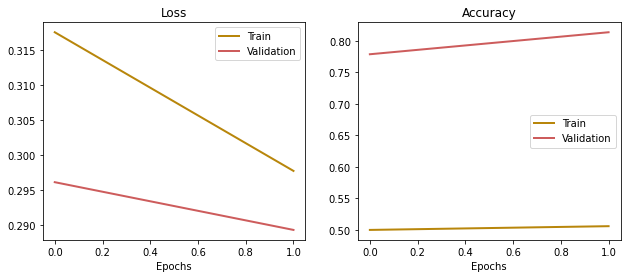

In [43]:
# grab history
history = bert_classification_model_history.history

# plot loss for train and validation
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.5,0.7)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss');

# plot accuracy for train and validation
ax = fig.add_subplot(1, 3, 2)
plt.plot(history['accuracy'], lw=2, color='darkgoldenrod')
plt.plot(history['val_accuracy'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
#plt.ylim(0.7,0.8)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Accuracy');

[Return to Top](#returnToTop)  
<a id = 'evaluation'></a>

# 4. Model Evaluation

In [63]:
#Run some tests
test_commment = ['what a stupid useless creature']
test_tokens = bert_tokenizer(test_commment,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')

test_predictions = bert_classification_model.predict([test_tokens.input_ids, test_tokens.token_type_ids, test_tokens.attention_mask], batch_size=32)
test_pred = np.where(test_predictions>=0.5, 1, 0)
target_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

pred_df = pd.DataFrame(data = test_pred, columns = target_names)
print(pred_df)

1/1 [==============================] - 0s 102ms/step
   toxic  severe_toxic  obscene  threat  insult  identity_hate
0      1             0        0       0       1              0


In [45]:
#Prepare test data
test_examples = [x.decode('utf-8') for x in test_comments.numpy()]

x_test = bert_tokenizer(test_examples,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_test = test_labels

In [46]:
test_examples[:10]

['this is bullshit that park can stay just as it is i bet for another 50yrs ',
 'one would hope the police will be interviewing the seemingly mentally disturbed people posting death threats on facebook all over a dog shooting of a dog with a proven record of violence extremely ignorant and stupid ',
 ' deists deny the trinity the inspiration of the bible the deity of christ miracles and any supernatural act of redemption or salvation deism pictures god as uncaring and uninvolved thomas jefferson was a famous deist referring often in his writings to providence http www gotquestions org deism html hope this helps ',
 'i hope i get the chance to think stupid kid when they find him wandering along ',
 'another factual error thomas didn t represent spenard legislative records refer to him as being from spenard but that s likely because his mailing address was at the spenard post office this was the case with helen beirne who actually lived in glen alps far as i know thomas lived on a tract 

In [47]:
# run the trained model on the test data (the model outputs probabilities)
#y_test_predictions = bert_classification_model(x_test)
y_test_predictions = bert_classification_model.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask], batch_size=32)

# apply the threshold function to create a 0, 1 outcome
y_test_pred = np.where(y_test_predictions>=0.5, 1, 0)
y_test_pred[:10] # first 10 only

238/238 [==============================] - 65s 274ms/step


array([[0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0]])

In [48]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred, target_names=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], zero_division = 0))

               precision    recall  f1-score   support

        toxic       0.64      0.66      0.65      3782
 severe_toxic       0.00      0.00      0.00         0
      obscene       0.00      0.00      0.00       332
       threat       0.00      0.00      0.00       127
       insult       0.66      0.57      0.62      3782
identity_hate       0.00      0.00      0.00       257

    micro avg       0.65      0.56      0.60      8280
    macro avg       0.22      0.21      0.21      8280
 weighted avg       0.60      0.56      0.58      8280
  samples avg       0.33      0.29      0.30      8280



In [49]:
from sklearn.metrics import hamming_loss
hamming_loss(y_test, y_test_pred)

0.13418859649122808

In [50]:
# #save the trained model
# from google.colab import drive
# drive.mount('/content/drive')

# saved_model_path = ('/content/drive/My Drive/Colab Notebooks/w266project/bert_classifier')
# bert_classification_model.save(saved_model_path, include_optimizer=False)